<a href="https://colab.research.google.com/github/khal-drog0/Breast_Cancer_Histopathology_Classification/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip3 install -q kaggle

from google.colab import files
files.upload()

! mkdir ~/.kaggle

! cp kaggle.json /root/.kaggle

! chmod 600 /root/.kaggle/kaggle.json

! kaggle datasets download -d paultimothymooney/breast-histopathology-images

! unzip breast-histopathology-images.zip

In [ ]:
import numpy as np
import pandas as pd
import os
import itertools
import os, stat, time
from os.path import dirname as up
import shutil
import glob
from PIL import Image

In [ ]:
from glob import glob
data = glob('IDC_regular_ps50_idx5/**/*.png', recursive = True)

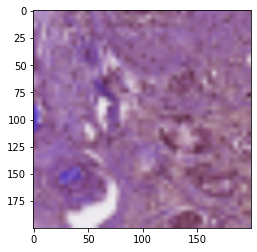

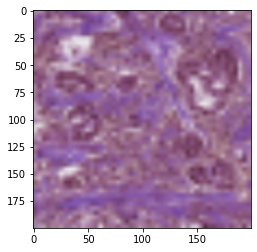

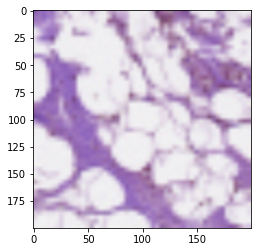

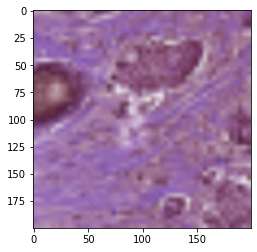

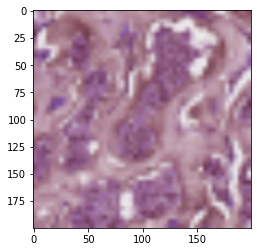

In [ ]:
import cv2
import matplotlib.pyplot as plt

for i in data[:5]:
    img = cv2.imread(i)
    img_1 = cv2.resize(img, (200, 200))
    plt.imshow(img_1, cmap = 'binary')
    plt.show()

In [ ]:
images = []
labels = []

for i in data[:15000]:
    if i.endswith('.png'):
        label = i[-5]
        img = cv2.imread(i)
        img_1 = cv2.resize(img, (100, 100))
        images.append(img_1)
        labels.append(label)

In [ ]:
len(images)

15000

In [ ]:
x = np.stack(images)

In [ ]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(labels)

In [ ]:
x = x / 255

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0, test_size = 0.2)

In [ ]:
print('len(x_train):', len(x_train))
print('len(x_test):', len(x_test))
print('len(y_train):', len(y_train))
print('len(y_test):', len(y_test))

len(x_train): 12000
len(x_test): 3000
len(y_train): 12000
len(y_test): 3000


# Building the Neural Network

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import models, layers

def modelEfficientNetB0():
    model = models.Sequential()
    model.add(EfficientNetB0(include_top = False, weights = 'imagenet', input_shape = (100, 100, 3)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(2, activation = 'sigmoid'))

    return model

model = modelEfficientNetB0()
model.summary()

16719872/16705208 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 4,052,133
Trainable params: 4,010,110
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr = 0.00001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad =  False)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Training the model

In [ ]:
history = model.fit(x, y, epochs = 100, validation_split = 0.4, batch_size = 56)

Epoch 1/100
161/161 [==============================] - 75s 324ms/step - loss: 0.5566 - acc: 0.7963 - val_loss: 0.6724 - val_acc: 0.6135
Epoch 2/100
161/161 [==============================] - 47s 291ms/step - loss: 0.4046 - acc: 0.8741 - val_loss: 0.7067 - val_acc: 0.4910
Epoch 3/100
161/161 [==============================] - 47s 292ms/step - loss: 0.3328 - acc: 0.8871 - val_loss: 0.7147 - val_acc: 0.6028
Epoch 4/100
161/161 [==============================] - 47s 291ms/step - loss: 0.2869 - acc: 0.8948 - val_loss: 0.7118 - val_acc: 0.6030
Epoch 5/100
161/161 [==============================] - ETA: 0s - loss: 0.2599 - acc: 0.9019

# Evaluating the model

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_data', 'test_data'])
plt.title('Loss Analysis')
plt.show()

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train_data', 'test_data'])
plt.title('Accuracy Analysis')
plt.show()

# Testing with random inputs

In [ ]:
IMG = Image.open('../breast-histopathology-images/10253/0/10253_idx5_x1001_y1101_class0.png')
print(type(IMG))

IMG = IMG.resize((100, 100))
IMG = np.array(IMG)
print('po array = {}'.format(IMG.shape))

IMG = np.true_divide(IMG, 255)
IMG = IMG.reshape(-1, 100, 100, 3)
print(type(IMG), IMG.shape)

predictions = model.predict_classes(IMG)
print(model)

predictions_c = model.predict_classes(IMG)
print(predictions, predictions_c)

model.predict_classes(IMG)
model.predict(IMG)
print(predictions_c)

In [ ]:
classes = {'TRAIN': ['Non Malignant (No Cancer)','Malignant'],
           'TEST': ['Non Malignant (No Cancer)', 'Malignant']}

predicted_class = classes['TRAIN'][predicitions_c[0]]
print('We think that is {}'.format(predicted_class.lower()))

# Saving the model

In [ ]:
model.save_weights('_model_.h5')

model_json = model.to_json()
with open('_model_.json', 'w') as json_file:
    json_file.write(model_json)

print('Model saved to the disk.')